In [262]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [263]:
from typing import Union

from dotenv import load_dotenv
load_dotenv(override=True)

from pydantic import BaseModel, Field
import requests
from io import BytesIO
from PIL import Image
import numpy as np
from plotreader.utils.structured_types.data import DataFrameRowsOnly
import pandas as pd
import seaborn as sns

import nest_asyncio
nest_asyncio.apply()

from llama_index.core.vector_stores.types import MetadataFilters, MetadataFilter, FilterOperator, FilterCondition
from llama_index.core.prompts import PromptTemplate
from llama_index.core.output_parsers.pydantic import PydanticOutputParser
from llama_index.core.schema import TextNode, IndexNode, NodeRelationship, RelatedNodeInfo, ImageNode
from llama_index.core.schema import ImageNode, NodeWithScore, MetadataMode
from llama_index.postprocessor.cohere_rerank import CohereRerank
from llama_index.core.schema import QueryBundle


import plotreader
from plotreader.utils.document import ScientificPaperHandler
from plotreader.utils.base import BasicAnthropicLLM

In [264]:
claude_mm_default = BasicAnthropicLLM(model='claude-3-5-sonnet-20240620', temperature = 0.0)

In [265]:
handler = ScientificPaperHandler(
    filepath="/Users/loyalshababo/dev/plotreader/sandbox/storage/tmp/nihms-1538039.pdf",
    document_id = "3de6841c-fba6-4124-a28a-2c53124202af",
    # filepath="/Users/loyalshababo/dev/plotreader/sandbox/storage/tmp/s42003-021-01878-9.pdf",
    # document_id = "b562c2f2-b776-4829-b18c-6c6ebf4f788d",
    name="nihms-1538039",
    desc="A scientific paper",
    storage_dir = "./storage",
    use_cache = False
)

In [266]:
fig_num = 3

filters = MetadataFilters(filters=[
    MetadataFilter(
        key="fig_refs", 
        value=f'Figure {fig_num}',
        operator=FilterOperator.TEXT_MATCH_LIST
    # ),
    # MetadataFilter(
    #     key="fig_refs", 
    #     value='Figure 2d',
    #     operator=FilterOperator.TEXT_MATCH_LIST
    # ),
    # MetadataFilter(
    #     key="fig_refs", 
    #     value='Figure 2e',
    #     operator=FilterOperator.TEXT_MATCH_LIST
    )],
    condition=FilterCondition.OR
)

In [267]:
query_tool = handler.query_engine_tool(metadata_filters=filters)

In [349]:
class Variable(BaseModel):
    """
    A variable is a quantity that is varied across the experimental conditions. It can be numeric, categorical, or both.
    Categories usually map to some visual feature like color, line style, or marker shape.
    Numerica variables usually map to coordinate axes.
    """
    name: str = Field(..., description="The name of the variable")
    categorical: bool = Field(..., description="Whether the variable has categorical axes")
    numeric: bool = Field(..., description="Whether the variable has numeric axes")

class Experiment(BaseModel):
    independent_variables: list[Variable]
    dependent_variables: list[Variable]

class Plot(BaseModel):
    name: str
    experiments: list[Experiment]

class Panel(BaseModel):
    name: str
    plots: list[Plot]

class Figure(BaseModel):
    name: str
    panels: list[Panel]
    # statistics: List[str]



In [350]:
output_parser = PydanticOutputParser(output_cls=Figure)

prompt = f"""
YOUR OVERALL JOB:
    You are an expert at extracting data from figures in scientific papers.
    You will always primarily look to the image of the figure.
    You will look to text to obtain more detail if necessary.
    When there is a discrepency between text and graphic, always defer to the graphic.

YOUR CURRENT TASK:
Complete the following task by visual inspection of the figure ONLY. Omit information if not available in the image.
For each plot in each panel of THE IMAGE of Fig. {fig_num}, determine the experiment in terms of Independent variables (IVs) and dependent variable (DV). 
By plot, we mean each set of axes or displays. Each panel can have multiple plots. See the json definition below for more.

Return your answer as structured data.
"""

prompt = PromptTemplate(prompt, output_parser=output_parser).format(llm=plotreader._MM_LLM)

In [351]:
response = query_tool(prompt)
nodes = response.raw_output.source_nodes
figure_struct = output_parser.parse(response.content)

In [352]:
nodes

[NodeWithScore(node=TextNode(id_='82233ee2-8144-4d94-9181-fa263e11f609', embedding=None, metadata={'Header_1': 'Results', 'Header_2': 'Designer ChRs and systemic AAVs enable minimally-invasive optogenetic excitation', 'Header_3': 'Designer ChRs and systemic AAVs enable minimally-invasive optogenetic excitation', 'experimental_variable_entities': ['ChRger1', 'ChRger2', 'ChRger3', 'CoChR', 'ChR2(H134R)', 'rAAV-PHP.eB', 'light intensity', 'stimulation frequency', 'photocurrent strength', 'spike fidelity', 'laser power'], 'fig_refs': ['Figure 3i', 'Figure 3j', 'Figure 3k', 'Figure 3l', 'Figure 3g', 'Figure 3m', 'Figure 3n', 'Figure 4a', 'Supplemental Figure 10', 'Supplemental Table 6', 'Supplemental Table 5']}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a71f2164-f8f5-48e0-be2c-3f5484fb2c5d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='7b659f8233a33154253211184f42d7c03aed827bbfd9936ed9ad29d

In [353]:
# find figure image
for node in nodes:
    if isinstance(node.node, ImageNode):
        response = requests.get(node.node.image_url)
        source_figure = Image.open(BytesIO(response.content))
        source_figure_summary = node.node.text

In [354]:
fig_description = f"{figure_struct.name}"

for panel in figure_struct.panels:
    fig_description += f"\n\tPanel: {panel.name}\n"
    for plot in panel.plots:
        fig_description += f"\n\t\tPlot: {plot.name}"
        for experiment in plot.experiments:
            fig_description += f"\n\t\t\t{experiment}"

print(fig_description)

Figure 3
	Panel: c

		Plot: Top plot
			independent_variables=[Variable(name='ChR variant', categorical=True, numeric=False)] dependent_variables=[Variable(name='Photocurrent', categorical=False, numeric=True)]
		Plot: Bottom plot
			independent_variables=[Variable(name='ChR variant', categorical=True, numeric=False)] dependent_variables=[Variable(name='Photocurrent', categorical=False, numeric=True)]
	Panel: d

		Plot: Spike fidelity vs Light intensity
			independent_variables=[Variable(name='Light intensity', categorical=False, numeric=True), Variable(name='ChR variant', categorical=True, numeric=False)] dependent_variables=[Variable(name='Spike fidelity', categorical=False, numeric=True)]
	Panel: e

		Plot: Spike fidelity vs Frequency
			independent_variables=[Variable(name='Frequency', categorical=False, numeric=True), Variable(name='ChR variant', categorical=True, numeric=False)] dependent_variables=[Variable(name='Spike fidelity', categorical=False, numeric=True)]
	Panel: g

		Pl

In [355]:
# select panel d (only one plot in panel)
panel = figure_struct.panels[4]
plot = panel.plots[0]
exp = plot.experiments[0]

In [356]:
class BoundingBox(BaseModel):
    left_x: float = Field(default = 0.0, description="The x-coordinate of the left side of the bounding box in the range 0.0 to 1.0")
    upper_y: float = Field(default = 0.0, description="The y-coordinate of the top side of the bounding box in the range 0.0 to 1.0")
    right_x: float = Field(default = 1.0, description="The x-coordinate of the right side of the bounding box in the range 0.0 to 1.0")
    lower_y: float = Field(default = 1.0, description="The y-coordinate of the bottom side of the bounding box")

In [357]:
output_parser = PydanticOutputParser(output_cls=BoundingBox)

In [358]:
PLOT_CROP_PROMPT = """
Provide a bounding box for panel {panel_name} (plot title/description: {plot_name}) in the provided figure. 
Be liberal with padding, we'd rather have extra that lose part of the panel."""

prompt = PromptTemplate(
    PLOT_CROP_PROMPT.format(panel_name=panel.name, plot_name=plot.name), 
    output_parser=output_parser
).format(llm=plotreader._MM_LLM)

In [359]:
response = claude_mm_default.message(
    prompt,
    images = [source_figure]
)

In [360]:
bbox = output_parser.parse(response.content[0].text)

In [361]:
padding = 0.1
bbox_cropped = BoundingBox()
bbox_cropped.left_x = np.max([0, bbox.left_x - padding])
bbox_cropped.upper_y = np.max([0, bbox.upper_y - padding])
bbox_cropped.right_x = np.min([1, bbox.right_x + padding])
bbox_cropped.lower_y = np.min([1, bbox.lower_y + padding])
bbox_cropped

BoundingBox(left_x=0.39, upper_y=0.48, right_x=0.84, lower_y=0.88)

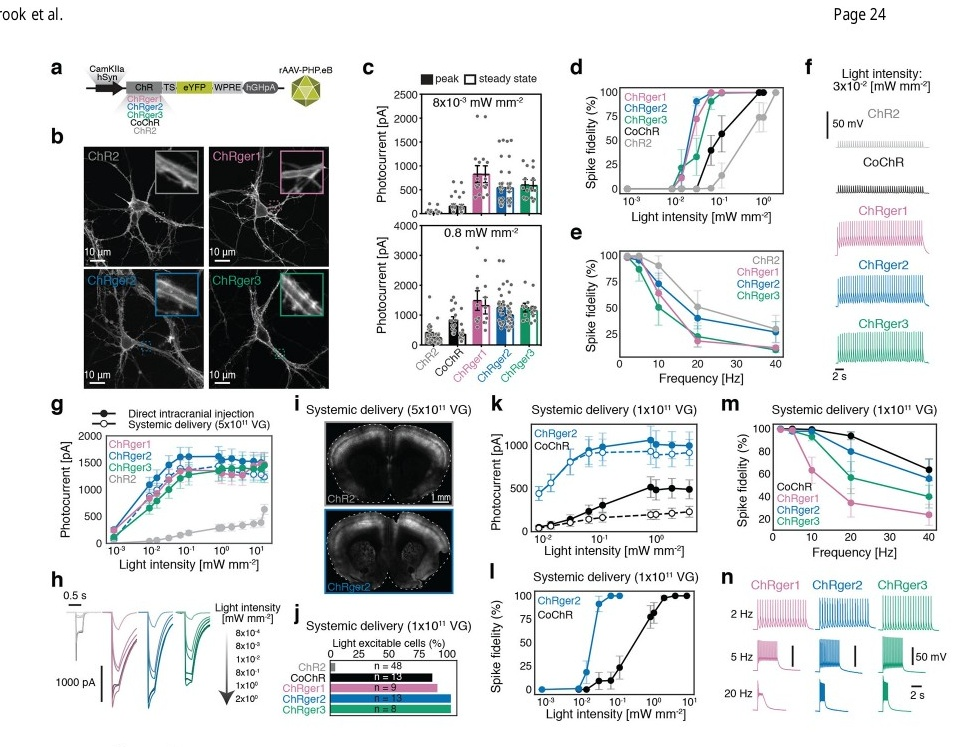

In [362]:
source_figure

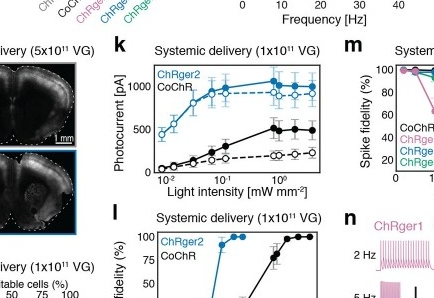

In [363]:
# use pillow to crop the image
fig_size = source_figure.size
bbox_px_vals = [bbox_cropped.left_x*fig_size[0], bbox_cropped.upper_y*fig_size[1], bbox_cropped.right_x*fig_size[0], bbox_cropped.lower_y*fig_size[1]]

# Crop the image using the extracted coordinates
cropped_img = source_figure.crop(bbox_px_vals)
cropped_img.save("cropped_img.png")
cropped_img = Image.open("cropped_img.png")
cropped_img

In [364]:
# make image node from cropped image
from plotreader.utils import image_to_base64

# convert PIL image to b64 encoded string
cropped_img_b64 = image_to_base64(cropped_img)

cropped_img_node = ImageNode(
    image=cropped_img_b64,
    image_url=None,
    metadata={
        "fig_refs": [f"Figure {fig_num}{panel.name}"],
    }
)

In [365]:
nodes.append(cropped_img_node)

In [439]:
class CategoryMap(BaseModel):
    type: str = Field(
        ...,
        description="The single visual signifier that this map corresponds to (e.g. color, marker, linestyle, etc.)"
    )
    values: dict[str, Union[str, list[float]]] = Field(
        ...,
        description="A map from Category > Label that can act as a legend for this variable. If the label is color, give the RGB value as a list of floats in [0,1]."
    )

class NumericAxis(BaseModel):
    numeric_values: list[float] = Field(default_factory = list, description="The numeric values used in the experimetnal design for this variable or any empty list if none.")
    unit: str = Field(..., description="The unit of the numeric values.")
    
class Variable(BaseModel):
    """
    A variable is a quantity that is varied across the experimental conditions. It can be numeric, categorical, or both.
    Categories usually map to some visual feature like color, line style, or marker shape.
    Numerica variables usually map to coordinate axes.
    """
    name: str = Field(..., description="The name of the variable")
    category_maps: list[CategoryMap] = Field(
        ...,
        description="Maps that essentially define the legend for this plot for categorical axes of variables."
    )
    numeric_axis: list[NumericAxis] = Field(
        ...,
        description="The numeric axis for this variable if it exists."
    )
    

class Parameter(BaseModel):
    """
    A parameter is a feature of the experiment that is necessary to know to fully describe it, but is not varied across the experimental conditions.
    """
    name: str = Field(..., description="The name of the parameter")
    values: Union[str, float] = Field(..., description="The value of the parameter")

class Experiment(BaseModel):
    """
    An experiment is a set of experimental conditions that are varied across the experimental conditions as well as additional parameters relevant to the experimetnal configuration.
    """
    independent_variables: list[Variable] = Field(..., description="The independent variables of the experiment. Together these define the experimental conditions. They can be numeric or categorical or both.")
    dependent_variables: list[Variable] = Field(..., description="The dependent variables of the experiment. These are often raw or summarized statistics of the data/measurements. They can be numeric or categorical or both.")
    parameters: list[Parameter] = Field(..., description="The parameters of the experiment. These are quantities that are necessary to know to fully describe the experimental design, but are not varied across the experimental conditions.")
    description: str = Field(..., description="A description of the experiment. This should be a short description that is easy to understand and interpret.")
    result: str = Field(..., description="The result of the experiment. This should be a short description that is easy to understand and interpret.")
    other_info: str = Field(..., description="Any other information about the experiment that is relevant to the experimental design or methodology.")



In [440]:
# let's try to consolidate the context into a summary and add important info we should consider for this figure
FIGURE_SUMMARY_PROMPT = """
You will be provided with a full Figure {fig_num} from a scientific paper, a cropped version with a panel of interest ({panel_name}), and retrieved text from that paper regarding the figure.
Your job is to extract all detailed information about the experimental variables used in a particular plot in the panel: {plot_name}.
The most important thing is that you include all details about the variables in the experiments from the text. DO NOT SUMMARIZE SETS OF QUANTITIES.
You should ensure that the information is only referencing the plot of interest by looking at the images, but only use the image to filter information, not to change it.
IMPORTANT:
    WHEN REFERENCING STYLE ATTRIBUTUES USE STRINGS THAT ARE COMPATIBLE WITH PLOTTING (e.g. 'o' for circles, RGB values for colors)
    ALL INFORMATION RELEVANT FOR DESCRIBING OR POTTING THE DATA SHOULD BE IN VARIABLE CLASSES.
    VARIABLES CAN HAVE BOTH NUMERIC AXES AND CATEGORICAL MAPS.

""".format(fig_num=fig_num, panel_name=panel.name, plot_name=plot.name)
FULL_PROMPT = FIGURE_SUMMARY_PROMPT + """

Structured representation of the plot experiment:
{plot_desc}

Retrieved text information regarding the figure as a whole:
{context}
"""

plot_desc = f"Plot: {plot.name}"
for experiment in plot.experiments:
    plot_desc += f"\n\t{experiment}"

text_nodes = [r for r in nodes if isinstance(r,NodeWithScore) and not isinstance(r.node, ImageNode)]
cohere_rerank = CohereRerank(top_n=5)
rerankded_text_nodes = cohere_rerank.postprocess_nodes(text_nodes, query_bundle=QueryBundle(query_str=FIGURE_SUMMARY_PROMPT))

context = "\n\n".join(
    [r.get_content(metadata_mode=MetadataMode.LLM) for r in rerankded_text_nodes]
)

full_prompt_formatted = FULL_PROMPT.format(plot_desc=plot_desc, context=context)

output_parser = PydanticOutputParser(output_cls=Experiment)
prompt = PromptTemplate(
    full_prompt_formatted,
    output_parser=output_parser
).format(llm=plotreader._MM_LLM)


In [441]:
plot_desc

"Plot: Photocurrent vs Light intensity\n\tindependent_variables=[Variable(name='Light intensity', categorical=False, numeric=True), Variable(name='ChR variant', categorical=True, numeric=False)] dependent_variables=[Variable(name='Photocurrent', categorical=False, numeric=True)]"

In [442]:
text_nodes

[NodeWithScore(node=TextNode(id_='82233ee2-8144-4d94-9181-fa263e11f609', embedding=None, metadata={'Header_1': 'Results', 'Header_2': 'Designer ChRs and systemic AAVs enable minimally-invasive optogenetic excitation', 'Header_3': 'Designer ChRs and systemic AAVs enable minimally-invasive optogenetic excitation', 'experimental_variable_entities': ['ChRger1', 'ChRger2', 'ChRger3', 'CoChR', 'ChR2(H134R)', 'rAAV-PHP.eB', 'light intensity', 'stimulation frequency', 'photocurrent strength', 'spike fidelity', 'laser power'], 'fig_refs': ['Figure 3i', 'Figure 3j', 'Figure 3k', 'Figure 3l', 'Figure 3g', 'Figure 3m', 'Figure 3n', 'Figure 4a', 'Supplemental Figure 10', 'Supplemental Table 6', 'Supplemental Table 5']}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a71f2164-f8f5-48e0-be2c-3f5484fb2c5d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='7b659f8233a33154253211184f42d7c03aed827bbfd9936ed9ad29d

In [443]:
rerankded_text_nodes

[NodeWithScore(node=TextNode(id_='82233ee2-8144-4d94-9181-fa263e11f609', embedding=None, metadata={'Header_1': 'Results', 'Header_2': 'Designer ChRs and systemic AAVs enable minimally-invasive optogenetic excitation', 'Header_3': 'Designer ChRs and systemic AAVs enable minimally-invasive optogenetic excitation', 'experimental_variable_entities': ['ChRger1', 'ChRger2', 'ChRger3', 'CoChR', 'ChR2(H134R)', 'rAAV-PHP.eB', 'light intensity', 'stimulation frequency', 'photocurrent strength', 'spike fidelity', 'laser power'], 'fig_refs': ['Figure 3i', 'Figure 3j', 'Figure 3k', 'Figure 3l', 'Figure 3g', 'Figure 3m', 'Figure 3n', 'Figure 4a', 'Supplemental Figure 10', 'Supplemental Table 6', 'Supplemental Table 5']}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a71f2164-f8f5-48e0-be2c-3f5484fb2c5d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='7b659f8233a33154253211184f42d7c03aed827bbfd9936ed9ad29d

In [444]:
response = claude_mm_default.message(
    prompt,
    images = [source_figure, cropped_img]
)

In [445]:
experiment_var = output_parser.parse(response.content[0].text)

In [446]:
pprint(experiment_var.json())

('{"independent_variables":[{"name":"Light '
 'intensity","category_maps":[],"numeric_axis":[{"numeric_values":[0.001,0.01,0.1,1.0,10.0,100.0],"unit":"mW '
 'mm^-2"}]},{"name":"ChR '
 'variant","category_maps":[{"type":"color","values":{"ChRger2":[0.0,1.0,1.0],"CoChR":[0.0,0.0,1.0]}}],"numeric_axis":[]}],"dependent_variables":[{"name":"Photocurrent","category_maps":[{"type":"linestyle","values":{"Peak":"solid","Steady-state":"dashed"}}],"numeric_axis":[{"numeric_values":[],"unit":"pA"}]}],"parameters":[{"name":"Viral '
 'delivery method","values":"Systemic delivery"},{"name":"Viral genome '
 'dose","values":"1x10^11 VG"}],"description":"This experiment compares the '
 'photocurrent strength of ChRger2 and CoChR across different light '
 'intensities after systemic delivery of the viral vectors.","result":"ChRger2 '
 'shows higher photocurrent strength compared to CoChR across all light '
 'intensities tested, with both peak and steady-state currents being '
 'consistently higher for Ch

In [398]:
details_text =response.content[0].text

In [399]:
print(response.content[0].text)

Based on the provided information and images, here are the details about the experimental variables used in the Photocurrent vs Light intensity plot (panel k):

Plot: Photocurrent vs Light intensity

Independent variables:
1. Light intensity (x-axis)
   - Categorical: False
   - Numeric: True
   - Units: mW mm^-2
   - Range: 10^-3 to 10^2 (log scale)

2. ChR variant (different lines)
   - Categorical: True
   - Numeric: False
   - Values: ChRger2, CoChR

Dependent variable:
1. Photocurrent (y-axis)
   - Categorical: False
   - Numeric: True
   - Units: pA
   - Range: 0 to approximately 1000 pA

Additional experimental details:
- Delivery method: Systemic delivery
- Viral vector: rAAV-PHP.eB
- Viral genome dose: 1x10^11 vg/animal
- Promoter: hSyn (human synapsin promoter)
- Recording location: PFC (prefrontal cortex) neurons
- Measurement type: Peak (solid line) and steady-state (dashed line) photocurrent
- Sample size: ChRger2 (n = 13 cells), CoChR (n = 14 cells)

Plot style:
- Marker:

In [404]:
prompt_base = """
Using the extracted information provided below as well as the image of the plot, please provide a detailed description of the experimental design of the plot using the schema at the end of this prompt.

Use all of the information to determine the independent and dependent variables of the experiment as well as parameters. Do not only look to any section names for the corresponding types of variables.

SOURCE:
Figure {fig_num}{panel_name}, plot {plot_name}

EXTRACTED INFORMATION:
{details_text}
""".format(
    fig_num = fig_num,
    panel_name = panel.name,
    plot_name = plot.name,
    details_text=details_text
)

output_parser = PydanticOutputParser(output_cls=Experiment)
prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

response = claude_mm_default.message(
    prompt,
    images = [cropped_img, source_figure]
)

experiment_var = output_parser.parse(response.content[0].text)



In [405]:
from pprint import pprint
pprint(experiment_var.json())


('{"independent_variables":[{"name":"Light '
 'intensity","categorical":false,"numeric":true},{"name":"ChR '
 'variant","categorical":true,"numeric":false}],"dependent_variables":[{"name":"Photocurrent","categorical":false,"numeric":true}],"parameters":[{"name":"Delivery '
 'method","values":"Systemic delivery"},{"name":"Viral '
 'vector","values":"rAAV-PHP.eB"},{"name":"Viral genome '
 'dose","values":"1x10^11 '
 'vg/animal"},{"name":"Promoter","values":"hSyn"},{"name":"Recording '
 'location","values":"PFC neurons"},{"name":"Measurement type","values":"Peak '
 'and steady-state photocurrent"},{"name":"Sample size '
 'ChRger2","values":13.0},{"name":"Sample size '
 'CoChR","values":14.0},{"name":"Plot '
 'scale","values":"Semi-log"},{"name":"Error bars","values":"Standard error of '
 'the mean (SEM)"}]}')


In [341]:
prompt_base = """
Please revise the description of the experiments in Figure {fig_num}{panel_name}, plot {plot_name}, using the cropped image of the panel and the new extracted information.

Previous description:
{plot_desc}

Extracted information:
{details_text}
""".format(
    fig_num = fig_num,
    panel_name = panel.name,
    plot_name = plot.name,
    details_text=details_text, plot_desc=plot_desc)

output_parser = PydanticOutputParser(output_cls=Plot)

prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

response = claude_mm_default.message(
    prompt,
    images = [source_figure, cropped_img]
)

plot_var = output_parser.parse(response.content[0].text)

In [342]:
plot_var

Plot(name='Photocurrent vs Light intensity (systemic delivery)', experiments=[Experiment(independent_variables=[Variable(name='Light intensity (mW mm^-2)', categorical=False), Variable(name='ChR variant', categorical=True)], dependent_variables=[Variable(name='Photocurrent (pA)', categorical=False)])])

In [330]:

class CategoryMap(BaseModel):
    type: str = Field(
        ...,
        description="The single visual signifier that this map corresponds to (e.g. color, marker, linestyle, etc.)"
    )
    values: dict[str, Union[str, list[float]]] = Field(
        ...,
        description="A map from Category > Label that can act as a legend for this variable. If the label is color, give the RGB value as a list of floats in [0,1]."
    )

class CategoricalVariable(BaseModel):
    name: str = Field(
        ...,
        description="The name of the independent variable."
    )
    labels: list[CategoryMap] = Field(
        ...,
        description="Maps that essentially define the legend for this plot."
    )

class NumericVariable(BaseModel):
    name: str
    values: list[float]
    unit: str

In [331]:


plot_struct_str = f"Plot: {plot.name}"
for experiment in plot.experiments:
    plot_struct_str += f"\n\t{experiment}"

ivs_with_values = []

for iv in exp.independent_variables:

    print(iv)
    if iv.categorical:

        var_cls = CategoricalVariable
        prompt = f"""
In Figure {fig_num}{panel.name}, plot title: {plot.name}, what values are taken by the independent variable {iv.name}?
To help you, I've provided information extracted from the text and images of the figure and plot.

IMPORTANT: 
    DO NOT CONFOUND THE VALUES OF AN AXIS WITH THE VALUES OF THE DATA POINT MARKERS. IT IS THE LATTER THAT WE CARE ABOUT.
    THE PROVIDED IMAGE IS A PADDED CROPPING OF THE PANEL OF INTEREST FROM THE FULL FIGURE, PLEASE IGNORE INFORMATION FROM NEARBY PANELS IN THE PADDING.

INFORMATIN FROM TEXT:
{details_text}

Return your answer as structured data.
"""
        
    else:
        var_cls = NumericVariable
        prompt = f"""
In Figure {fig_num}{panel.name}, plot title: {plot.name}, what values are taken by the independent variable {iv.name}?
To help you, I've provided information extracted from the text and images of the figure and plot.

IMPORTANT: 
    DO NOT CONFOUND THE VALUES OF AN AXIS WITH THE VALUES OF THE DATA POINT MARKERS. IT IS THE LATTER THAT WE CARE ABOUT.
    THE PROVIDED IMAGE IS A PADDED CROPPING OF THE PANEL OF INTEREST FROM THE FULL FIGURE, PLEASE IGNORE INFORMATION FROM NEARBY PANELS IN THE PADDING.

INFORMATIN FROM TEXT:
{details_text}

Return your answer as structured data.
        """

    # prompt = f"""In Figure 2, what categories are shown for the independent variable: {exp.independent_variables[1].name}?

    # What categories are shown in this plot for the independent variable: {exp.independent_variables[1].name}?

    # {our_info}
    # """

    output_parser = PydanticOutputParser(output_cls=var_cls)
    prompt = PromptTemplate(prompt, output_parser=output_parser).format(llm=plotreader._MM_LLM)

    response = claude_mm_default.message(
        prompt,
        images = [source_figure, cropped_img]
    )
    text = response.content[0].text

    ivs_with_values.append(output_parser.parse(text))
# print(var_struct)


name='Light intensity (mW mm^-2)' categorical=False
name='ChR variant' categorical=True


In [332]:
ivs_with_values

[NumericVariable(name='Light intensity', values=[0.001, 0.01, 0.1, 1.0, 10.0], unit='mW mm^-2'),
 CategoricalVariable(name='ChR variant', labels=[CategoryMap(type='color', values={'ChRger2': [0.0, 0.447, 0.698], 'CoChR': [0.0, 0.0, 0.0]}), CategoryMap(type='marker', values={'ChRger2': 'o', 'CoChR': 's'}), CategoryMap(type='linestyle', values={'Peak current': 'solid', 'Steady-state current': 'dashed'})])]

In [325]:
ivs_to_use = ivs_with_values

In [326]:
output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


columns = {iv.name: pd.Series() for iv in exp.independent_variables}
dep_var = exp.dependent_variables[0]
columns.update({dep_var.name: pd.Series()})
df = pd.DataFrame(columns)

prompt_base = """
In Figure {fig_num}{panel_name}, plot {plot_name}, what are the values for the dependent variable {dep_var_name}?
Get the value for each condition. To help, here is our current belief on the independent variables and their values for this plot:
{ind_vars}

And here is some information that could be useful:
{text_info}

Return your data using the following column schema: {schema}.
""".format(
    fig_num = fig_num,
    panel_name = panel.name, 
    # dep_var_stat = dep_var.statistics[0],
    plot_name = plot.name,
    dep_var_name = dep_var.name,
    ind_vars = "\n".join([str(iv) for iv in ivs_to_use]),
    schema = ", ".join(df.columns),
    text_info = details_text,
).replace("{","<").replace("}",">")

prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

data_response = claude_mm_default.message(
    prompt,
    images = [cropped_img]
)
panel_df = output_parser.parse(data_response.content[0].text).to_df(existing_df=df)


/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


In [327]:
panel_df

,Light intensity (mW mm^-2),ChR variant,Photocurrent (pA)
0,0.001,ChRger2,400
1,0.010,ChRger2,750
2,0.100,ChRger2,900
3,1.000,ChRger2,950
4,10.000,ChRger2,975
5,0.001,CoChR,50
6,0.010,CoChR,150
7,0.100,CoChR,300
8,1.000,CoChR,450
9,10.000,CoChR,500


[]

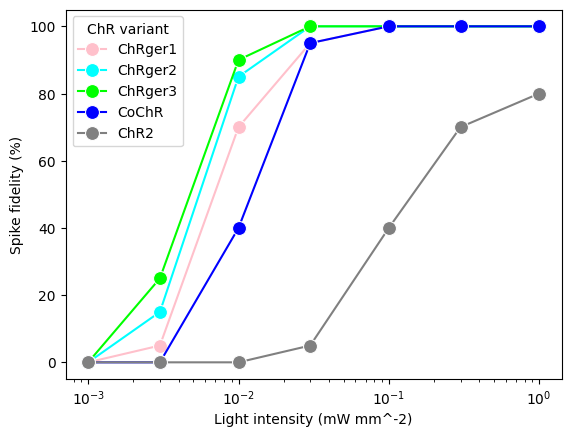

In [297]:
chr_variant_iv = [iv for iv in ivs_to_use if iv.name == 'ChR variant'][0]
chr_variant_order = [k for k,v in chr_variant_iv.values.items() if k in panel_df['ChR variant'].unique()]
palette = [np.array(v)/255 for k,v in chr_variant_iv.values.items() if k in chr_variant_order]

axes = sns.lineplot(
    data=panel_df,
    x='Light intensity (mW mm^-2)',
    y='Spike fidelity (%)',
    hue='ChR variant',
    marker='o',
    hue_order=chr_variant_order,
    markersize=10,
    palette=palette
)
axes.semilogx()


In [328]:
chr_variant_iv = [iv for iv in ivs_to_use if iv.name == 'ChR variant'][0]

In [329]:
chr_variant_iv

CategoricalVariable(name='ChR variant', label_type='color and marker', values=[CategoryMap(type='color', values={'ChRger2': [0.0, 0.447, 0.698], 'CoChR': [0.0, 0.0, 0.0]}), CategoryMap(type='marker', values={'ChRger2': 'o', 'CoChR': 's'}), CategoryMap(type='linestyle', values={'Peak current': 'solid', 'Steady-state current': 'dashed'})])

In [ ]:
chr_variant_iv = [iv for iv in ivs_to_use if iv.name == 'ChR variant'][0]
chr_variant_order = [k for k,v in chr_variant_iv.values.items() if k in panel_df['ChR variant'].unique()]
palette = [np.array(v) for k,v in chr_variant_iv.values.items() if k in chr_variant_order]

axes = sns.lineplot(
    data=panel_df,
    x='Wavelength',
    y='Normalized photocurrent',
    hue='ChR variant',
    marker='o',
    hue_order=chr_variant_order,
    markersize=10,
    palette=palette
)


In [298]:
chr_variant_iv = [iv for iv in ivs_to_use if iv.name == 'ChR variant'][0]
chr_variant_order = [k for k,v in chr_variant_iv.values.items() if k in panel_df['ChR variant'].unique()]
palette = [np.array(v) for k,v in chr_variant_iv.values.items() if k in chr_variant_order]

axes = sns.lineplot(
    data=panel_df,
    x='Wavelength',
    y='Normalized photocurrent',
    hue='ChR variant',
    marker='o',
    hue_order=chr_variant_order,
    markersize=10,
    palette=palette
)


ValueError: Could not interpret value `Wavelength` for `x`. An entry with this name does not appear in `data`.

KeyboardInterrupt: 

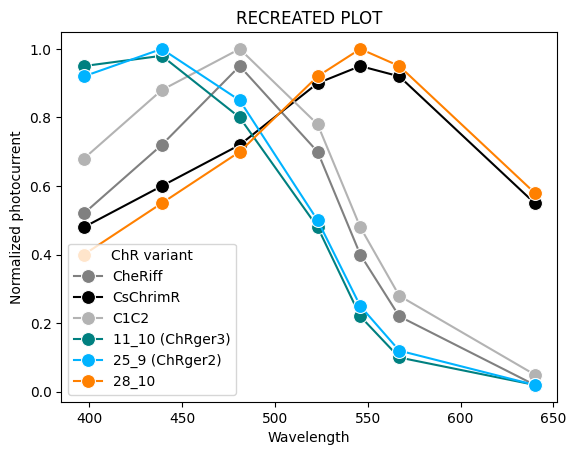

In [ ]:
from matplotlib import pyplot as plt
from PIL import Image


fig, axes = plt.subplots()
sns.lineplot(
    data=panel_df,
    x='Wavelength',
    y='Normalized photocurrent',
    hue='ChR variant',
    marker='o',
    hue_order=chr_variant_order,
    markersize=10,
    palette=palette,
    ax=axes
)
# sns.lineplot(
#     data=panel_df,
#     x='Light intensity (mW mm^-2)',
#     y='Spike fidelity (%)',
#     hue='ChR variant',
#     marker='o',
#     hue_order=chr_variant_order,
#     markersize=10,
#     palette=palette,
#     ax=axes
# )
# axes.semilogx()
axes.set_title(f"RECREATED PLOT")
# axes.set_xscale('log')

# get plot as PIL Image
fig.savefig('plot_0.png')

generated_img_loop = Image.open('plot_0.png')
panel_df_loop = panel_df

refined_feedback = "No previous changes."
claude_mm_critique = BasicAnthropicLLM(model="claude-3-5-sonnet-20240620", temperature=0.1)
for iter in range(20):

    


    prompt_base = f"""
We have extracted data from figure {fig_num}{panel.name}, plot {plot.name}. 
You will be given the extracted data as a table.
You will also be given the source figure and a recreation of the plot using our extracted data.
(Note: the recreation may vary in stylistic choices (e.g. color, linestyle) and in properties like axes ranges or aspect ratio but this not what we are concerned with.)
List the three largest quantitative differences between the values of the data in the rereation versuse source figure.
If possible, prioritize general differences that are common across many categories such that they can all be corrected together.
Be specific and refer to specific quantities and values. Do not suggest difference that change the number of rows.

DataFrame:
{panel_df_loop.to_markdown()}
    """


    response__loop = claude_mm_critique.message(prompt_base, images = [cropped_img, generated_img_loop])

    feedback_loop = response__loop.content[0].text
    print(feedback_loop)

    refined_feedback = feedback_loop

    # refined_feedback_response = claude_mm_default.message(
    #     f"Choose the two most important changes from the suggested list that will result in the largest quantitative improvement in matching the source figure: \n{feedback_loop}",
    #     images = [cropped_img, generated_img_loop]
    # )
    # refined_feedback = refined_feedback_response.content[0].text
    # print(refined_feedback)



    output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


    columns = {iv.name: pd.Series() for iv in exp.independent_variables}
    dep_var = exp.dependent_variables[0]
    columns.update({dep_var.name: pd.Series()})
    df = pd.DataFrame(columns)

    prompt_base = """
You were previously given the following task:
"In Figure 2{panel_name}, plot {plot_name}, what are the values for the dependent variable {dep_var_name}?"

Here is you the dataframe output from your previous response:
{df_table}

And here is some information that could be useful:
{text_info}

We have reviewed your response and notice these important changes that will improve the match to the source figure:
{feedback}

Please revise your response by incorporating these changes. 
Adjust the values in the dataframe in the most parsimonious way possible to match the source figure.
Reference the source text in the context if you think there is information that will inform these changes (e.g changing independent variable values).
This could mean scaling or shift all or a subset of the rows and/or columns, but do not add or delete rows.
Please let any specific changes inform nearby values if that is necessary to match the source figure.

And remember, our goal is to match the data points in the plot EXACTLY - not just the shapes or trends.

Return your data using the following column schema: {schema}.
    """.format(
        fig_num = fig_num,
        panel_name = panel.name, 
        # dep_var_stat = dep_var.statistics[0],
        plot_name = plot.name,
        dep_var_name = dep_var.name,
        ind_vars = "\n".join([str(iv) for iv in ivs_with_values]),
        schema = ", ".join(df.columns),
        feedback = feedback_loop,
        df_table = panel_df_loop.to_markdown(),
        text_info = details_text,
    ).replace("{","<").replace("}",">")
    prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

    data_response_loop = claude_mm_default.message(prompt, images = [cropped_img, generated_img_loop])
    panel_df_loop = output_parser.parse(data_response_loop.content[0].text).to_df(existing_df=df)

    # Create a new figure and axes
    fig, axes = plt.subplots()
    
    # Plot the line plot on the new axes
    # sns.lineplot(
    #     data=panel_df_loop,
    #     x='Light intensity',
    #     y='Spike fidelity',
    #     hue='ChR variant',
    #     marker='o',
    #     # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    #     markersize=10,
    #     ax=axes
    # )
    # sns.lineplot(
    #     data=panel_df_loop,
    #     x='Wavelength',
    #     y='Normalized photocurrent',
    #     hue='ChR variant',
    #     marker='o',
    #     hue_order=chr_variant_order,
    #     markersize=10,
    #     palette=palette,
    #     ax=axes
    # )
    sns.lineplot(
        data=panel_df_loop,
        x='Light intensity (mW mm^-2)',
        y='Spike fidelity (%)',
        hue='ChR variant',
        marker='o',
        hue_order=chr_variant_order,
        markersize=10,
        palette=palette,
        ax=axes
    )
    axes.semilogx()
    axes.set_title(f"RECREATED PLOT")
    # axes.set_xscale('log')

    fig.savefig(f'plot_{iter+1}.png')
    generated_img_loop = Image.open(f'plot_{iter+1}.png')

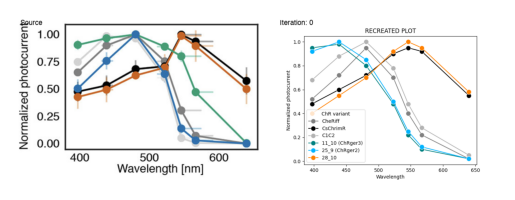

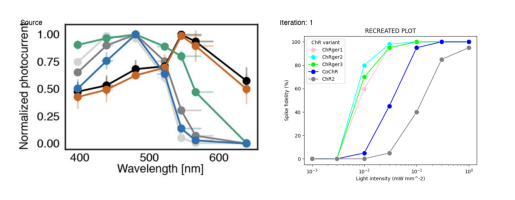

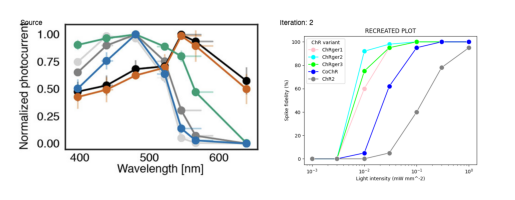

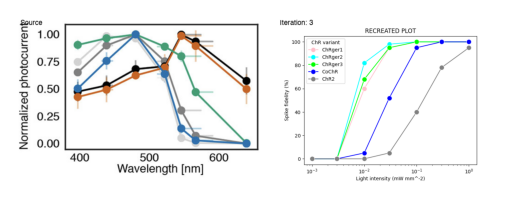

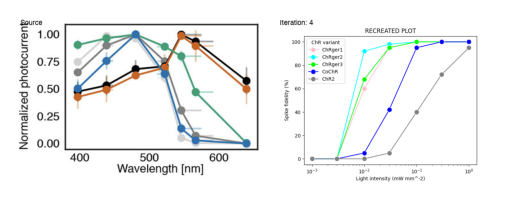

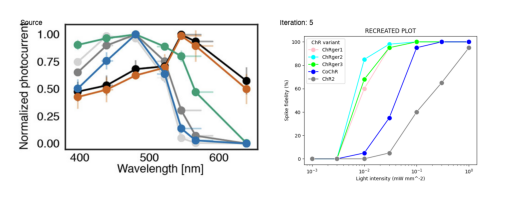

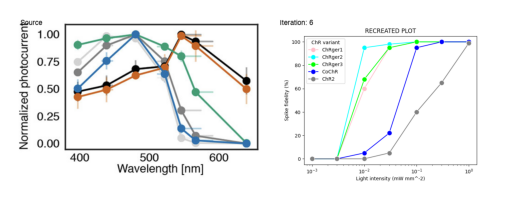

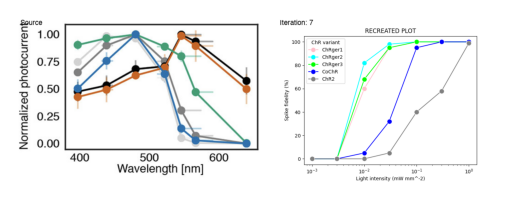

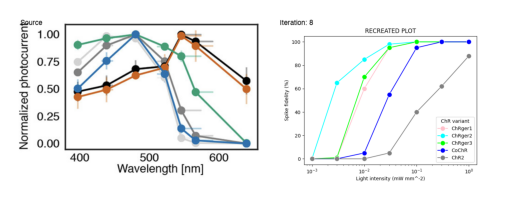

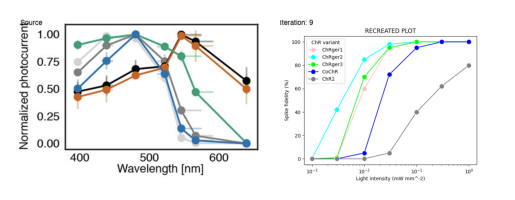

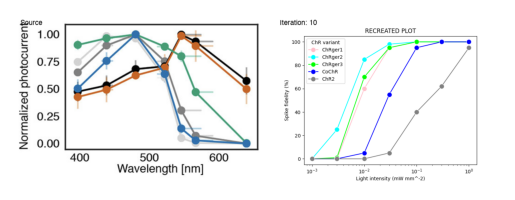

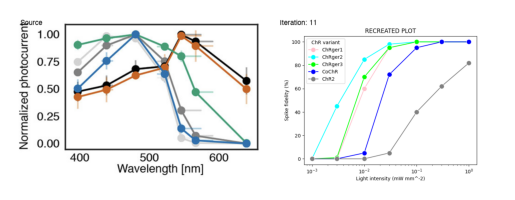

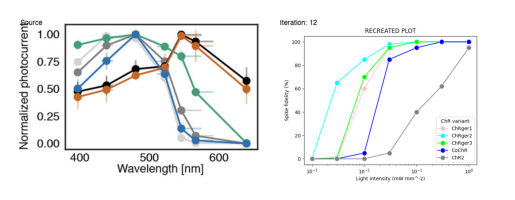

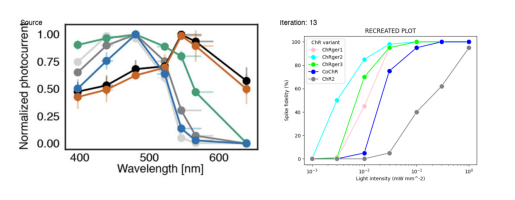

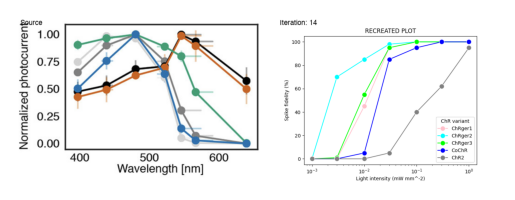

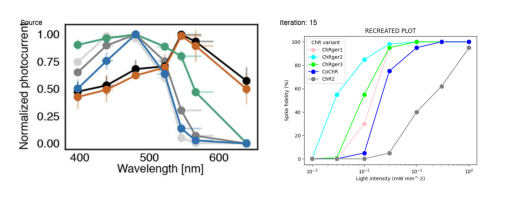

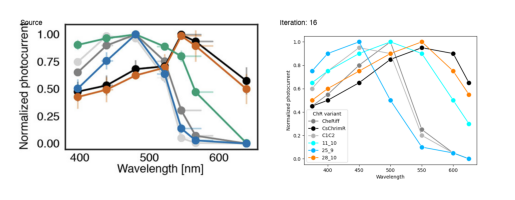

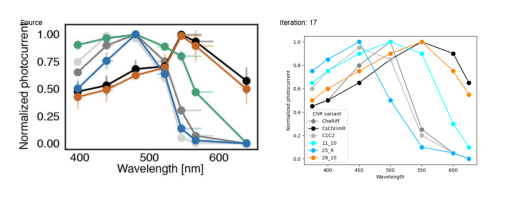

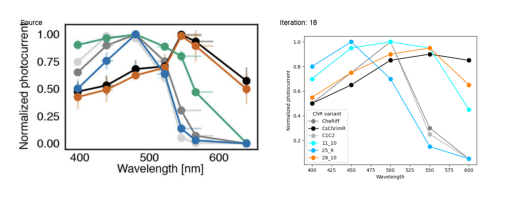

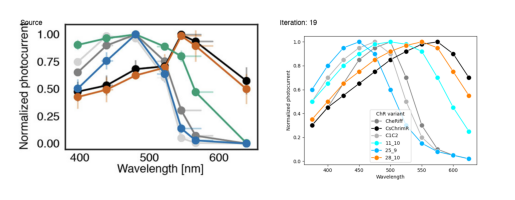

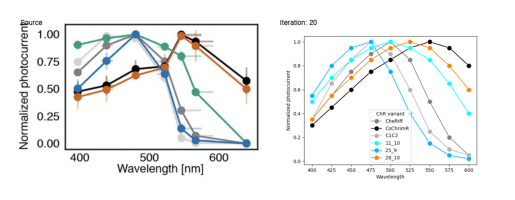

MP4 video saved as 'comparison.mp4'


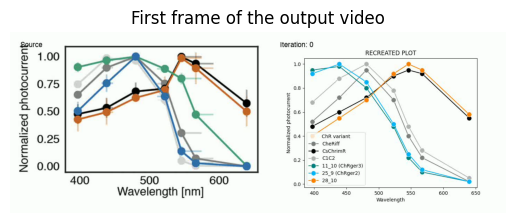

In [ ]:
source_panel = '/Users/loyalshababo/dev/plotreader/sandbox/2d_screenshot.png'
generated_fig_panel_path_base = "/Users/loyalshababo/dev/plotreader/sandbox/plot_{iter}.png"

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import cv2
import numpy as np

def create_side_by_side_image(source_img, generated_img, iter_number):
    # Resize both images to have the same height
    target_height = 480  # You can adjust this value as needed
    source_img_resized = source_img.resize((int(source_img.width * target_height / source_img.height), target_height))
    generated_img_resized = generated_img.resize((int(generated_img.width * target_height / generated_img.height), target_height))
    
    # Create a new image with the width of both resized images and the target height, plus padding
    padding = 20  # Adjust padding as needed
    total_width = source_img_resized.width + generated_img_resized.width + (3 * padding)  # Extra padding between images
    total_height = target_height + (2 * padding)
    combined_img = Image.new('RGB', (total_width, total_height), color='white')
    
    # Paste the resized source image on the left
    combined_img.paste(source_img_resized, (padding, padding))
    
    # Paste the resized generated image on the right
    combined_img.paste(generated_img_resized, (source_img_resized.width + (2 * padding), padding))
    
    # Add titles to the images
    draw = ImageDraw.Draw(combined_img)
    font = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", 20)
    
    # Add "Source" title
    draw.text((padding + 10, padding + 10), "Source", fill="black", font=font)
    
    # Add "Iteration: iter_number" title
    draw.text((source_img_resized.width + (2 * padding) + 10, padding + 10), f"Iteration: {iter_number}", fill="black", font=font)
    
    return combined_img

# Load the source panel image
source_img = Image.open(source_panel)

# Create a list to store the frames
frames = []

# Generate frames for each iteration
for iter in range(21):  # 0 to 10
    generated_img_path = generated_fig_panel_path_base.format(iter=iter)
    try:
        generated_img = Image.open(generated_img_path)
        
        # Create the side-by-side image with titles
        combined_img = create_side_by_side_image(source_img, generated_img, iter)
        
        # Convert PIL Image to numpy array
        frame = cv2.cvtColor(np.array(combined_img), cv2.COLOR_RGB2BGR)
        
        # Append the combined image to frames
        frames.append(frame)
    except FileNotFoundError:
        print(f"Warning: Image file not found for iteration {iter}")

# Check if we have any frames
if not frames:
    print("No frames were generated. Check if the image files exist.")
else:
    # Define the output video file
    output_file = 'comparison.mp4'

    # Get the frame size
    height, width, layers = frames[0].shape

    # Create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_file, fourcc, 1.0, (width, height))  # 2.0 fps for 5 seconds total with 10 frames

    # Write frames to video
    for frame in frames:
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
        out.write(frame)

    # Release the VideoWriter
    out.release()

    print(f"MP4 video saved as '{output_file}'")

# Verify the output video
cap = cv2.VideoCapture(output_file)
if cap.isOpened():
    ret, frame = cap.read()
    if ret:
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("First frame of the output video")
        plt.show()
    else:
        print("Failed to read the first frame")
    cap.release()
else:
    print("Failed to open the output video file")
